------------------------------------------------------------------------------------------------

<h3>Dataset: </h3>
adult.csv

<h3>Objective: </h3>
Build a classification model that predicts if a person makes over 50k or not

------------------------------------------------------------------------------------------------

### Import Libraries

In [1]:
# import basic libraries
import pandas as pd
import numpy as np

# import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import libraries for  modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# import libraries for data encoding, normalization and standarization
try:
    import category_encoders as ce
except:
    !pip install category_encoders
    import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler    

# import library for sampling
try:
    from imblearn.over_sampling import SMOTE
except:
    !pip install imblearn
    from imblearn.over_sampling import SMOTE

# import libraries for model performance evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

### Reusable Functions

#### 1. Function to generate a clean (lower triangular) heatmap visual

In [2]:
def show_heat_map(data):
    """
    function show_heat_map() to generate a heatmap for showing a correlation between features
    Input(s): 
        - data: as dataframe
    Output(s):
        - None
    """
    corr_matrix = data.corr()
    # mask the upper triangle
    plt.figure(figsize=(12, 10))
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data.corr(), mask=mask, annot=True)

#### 2. Function to identify outliers in input feature using Z-score

In [3]:
def identify_outliers_Zscore(data, feature):
    """
    function identify_outliers_Zscore() to identify the outliers in input dataframe
    Method: Z-score, permissible values bounded within -3 <= z-score <= 3
    Input(s): 
        - data: as dataframe
        - feature: feature on which outliers are to be identified
    Output(s):
        - indices - list of indexes of the outliers
    """
    mean = np.mean(data[feature])
    std_dev = np.std(data[feature])
    indices = []
    for index, value in data[feature].iteritems():
        z_score = (value-mean)/std_dev
        if abs(z_score) > 3:
            indices.append(index)
    return indices

#### 3. Function to create a stacked histogram

In [4]:
def show_stacked_histogram(dimension, category):
    """
    function show_stacked_histogram() to create and print a stacked histogram
    Method: uses seaborn library, histplot function
    Input(s): 
        - dimension: feature to be plottled on x-axis
        - category: feature to be used for stacking the histogram bars
    Output(s):
        - none
    """
    f = plt.figure(figsize=(18,4))
    ax = f.add_subplot()
    plt.xticks(rotation=45)
    sns.histplot(x=dimension, hue=category, multiple="stack")
    plt.show()

### Import Dataset

In [5]:
# load the dataset
dataset = pd.read_csv('adult.csv')

------------------------------------------------------------------------------------------------

### Data Exploration & Visualization

In [6]:
# view the shape of dataset
print(dataset.shape)
print('\nThe given dataset has {} rows and {} columns'.format(dataset.shape[0], dataset.shape[1]))

(48842, 15)

The given dataset has 48842 rows and 15 columns


In [7]:
# view summary of dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


##### Observations:
* The dataset is a mix of numerical and categorical features
* All the rows in dataset have non-null values in all the features
* Some features have special characters "-" in their name. We will rename such features so that there are no issues while performing operations on them later

In [8]:
# renaming features having special character (-) with proper names
dataset.rename(columns={'capital-gain': 'capitalGain', 'capital-loss': 'capitalLoss', 
                        'native-country': 'nativeCountry','hours-per-week': 'hoursPerWeek',
                        'educational-num': 'educationalNum', 'marital-status': 'maritalStatus'}, inplace=True)
print(dataset.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'educationalNum',
       'maritalStatus', 'occupation', 'relationship', 'race', 'gender',
       'capitalGain', 'capitalLoss', 'hoursPerWeek', 'nativeCountry',
       'income'],
      dtype='object')


In [9]:
# view first 5 rows in dataset
dataset.head(5)

,age,workclass,fnlwgt,education,educationalNum,maritalStatus,occupation,relationship,race,gender,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [10]:
# view last 5 rows in dataset
dataset.tail(5)

,age,workclass,fnlwgt,education,educationalNum,maritalStatus,occupation,relationship,race,gender,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
48841,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


Let's identify the numerical and categorical features in the dataset.

In [11]:
# numerical features
numerical_features = [var for var in dataset.columns if dataset[var].dtype=='int64']
print('There are {} numerical features in dataset listed below:\n{}'.format(len(numerical_features), numerical_features))

# categorical features
categorical_features = [var for var in dataset.columns if dataset[var].dtype=='O']
print('\nThere are {} categorical features in dataset listed below:\n{}'.format(len(categorical_features), categorical_features))

There are 6 numerical features in dataset listed below:
['age', 'fnlwgt', 'educationalNum', 'capitalGain', 'capitalLoss', 'hoursPerWeek']

There are 9 categorical features in dataset listed below:
['workclass', 'education', 'maritalStatus', 'occupation', 'relationship', 'race', 'gender', 'nativeCountry', 'income']


#### Let's review the numerical features.

In [12]:
# view the basic statistical details of numerical features
dataset[numerical_features].describe()

,age,fnlwgt,educationalNum,capitalGain,capitalLoss,hoursPerWeek
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


##### Observations: 
1. age varies from 17 years to 90 years <br>
2. fnlwgt is widely spread <br>
3. educationalNum varies from 1 to 16
4. capital gain and capital loss are heavily biased with 0 value
5. working hours per week vary from 1 to 99 hrs

#### Let's review the categorical features

In [13]:
# view the unique values for categorical features and their respective counts
for v in categorical_features:
    print ("\n----- %s -----" % v)
    print (dataset[v].value_counts())


----- workclass -----
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

----- education -----
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64

----- maritalStatus -----
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: maritalStatus, dtype: int64

----- occupation -----
Prof-s

##### Observations:
1. All the categorical features have limited set of values
2. workclass, marital status, occupation, relationship, race, gender and native country seem to be nominal in nature
3. education seems to be an ordinal feature
4. workclass, education and native country have "?" special character in the values for some data rows which should be handled during pre-processing of data

#### Next, we will plot a histogram of all features to see their distribution in dataset w.r.t. income

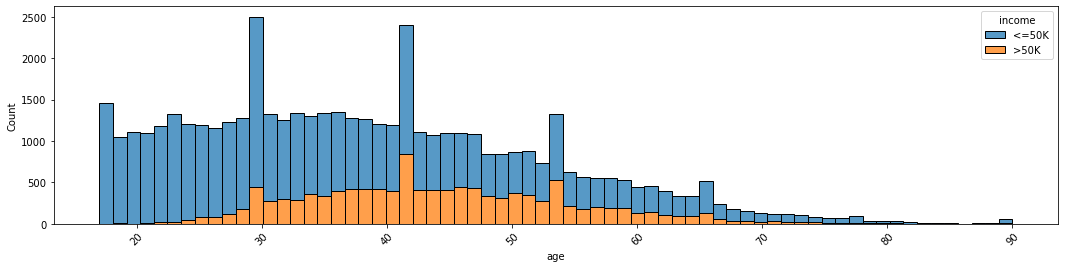

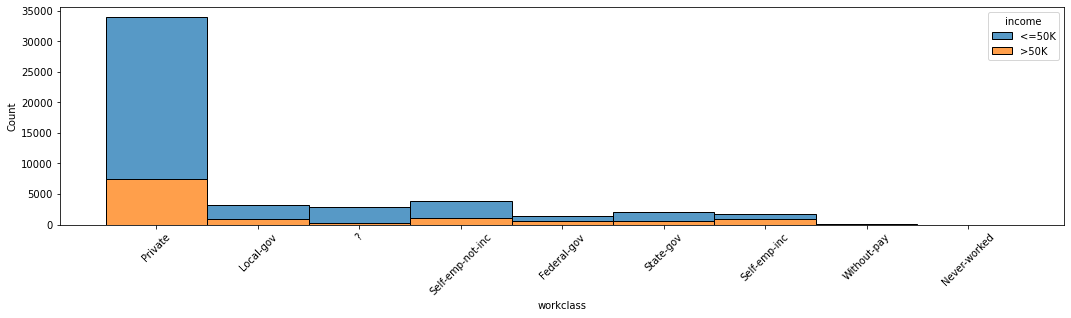

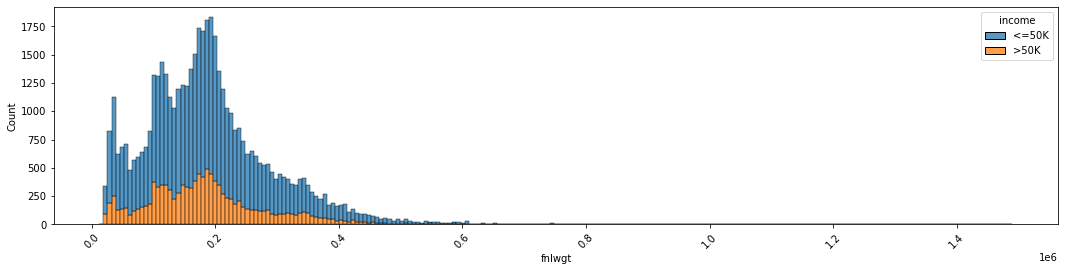

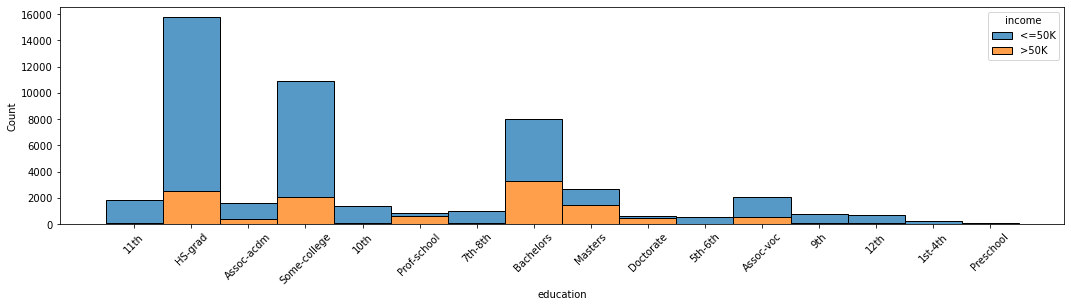

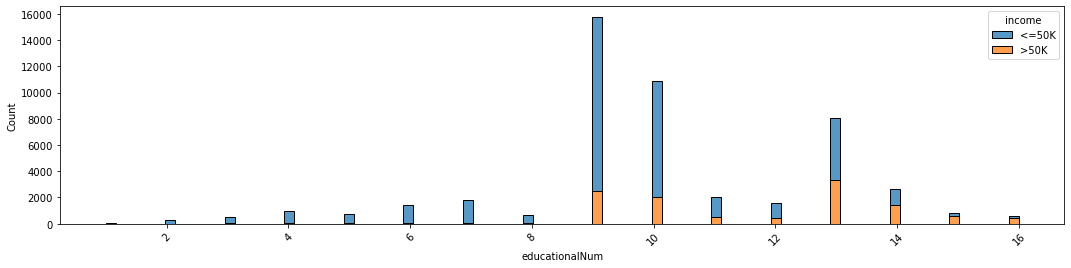

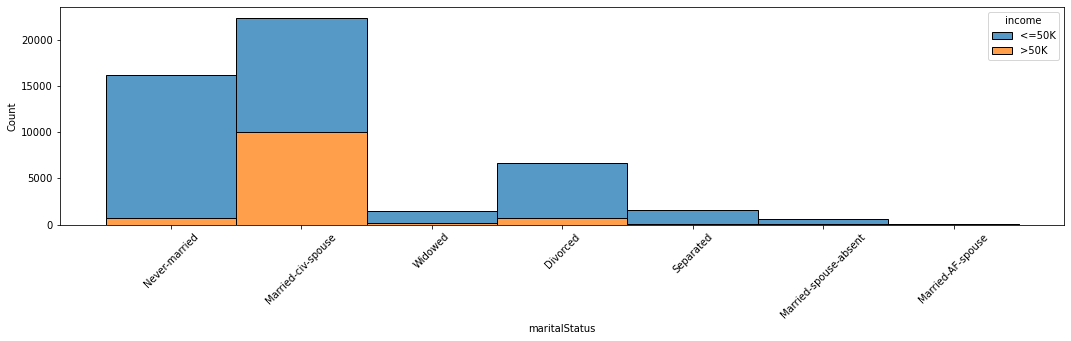

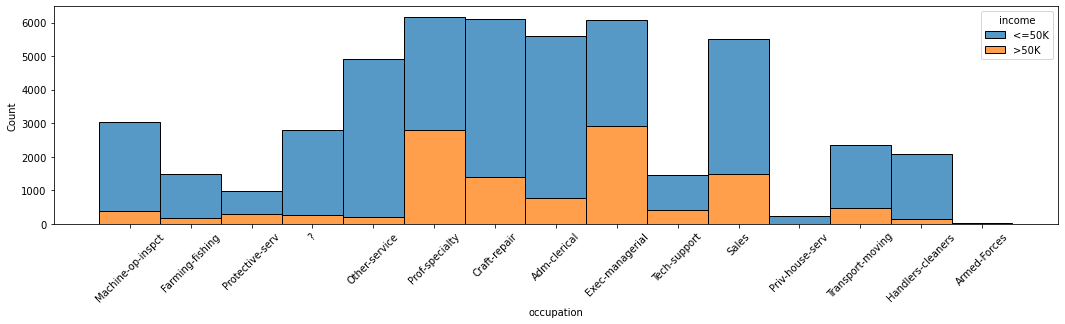

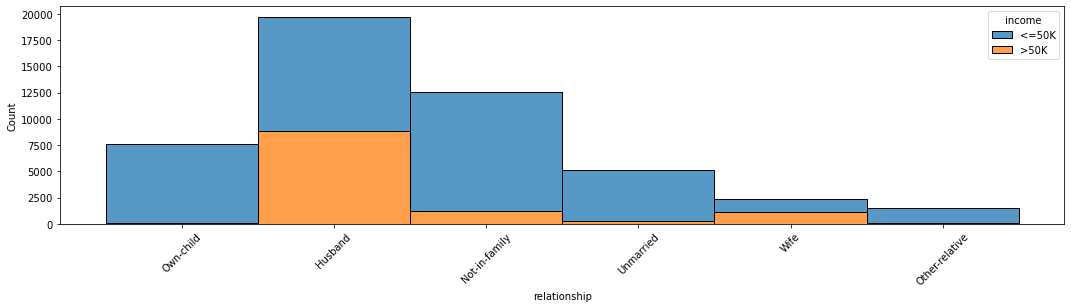

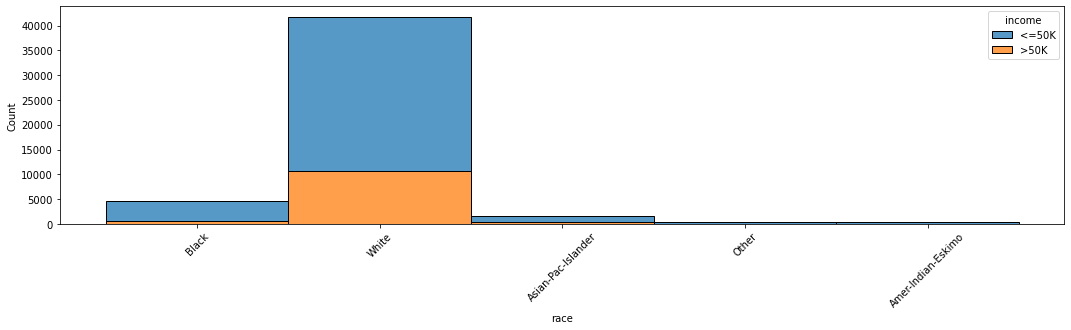

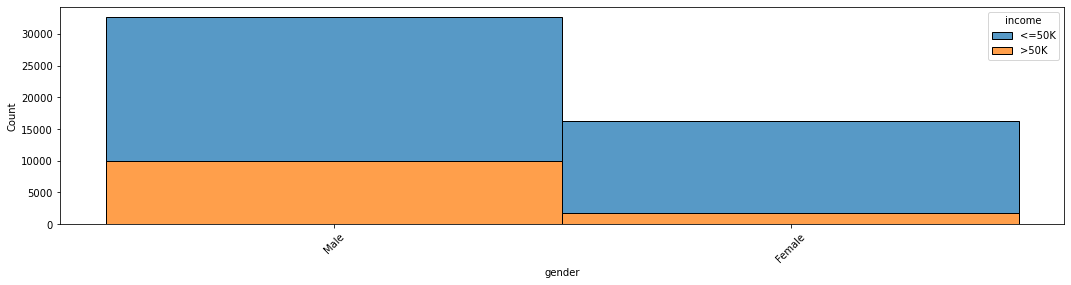

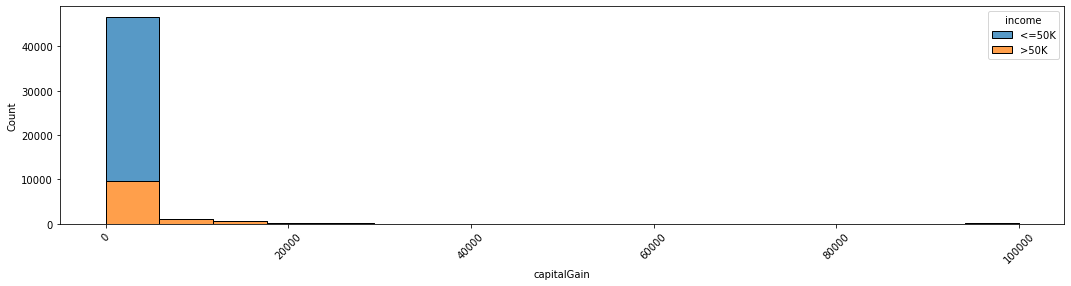

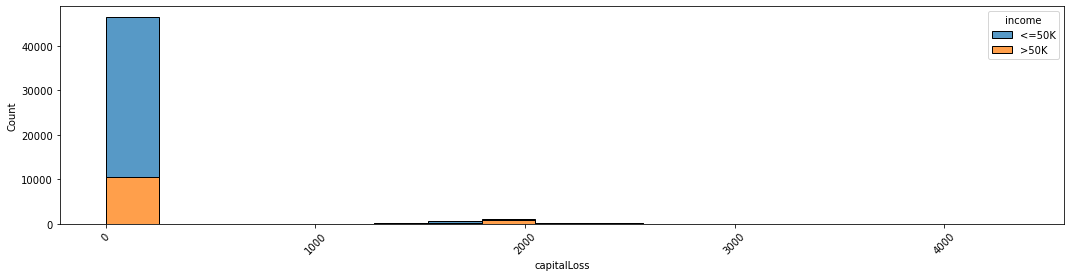

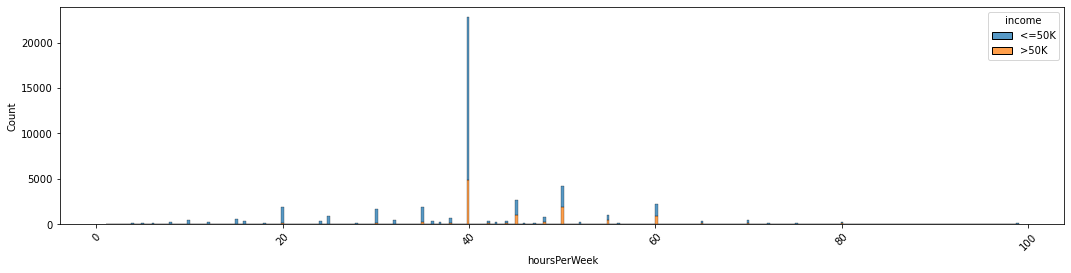

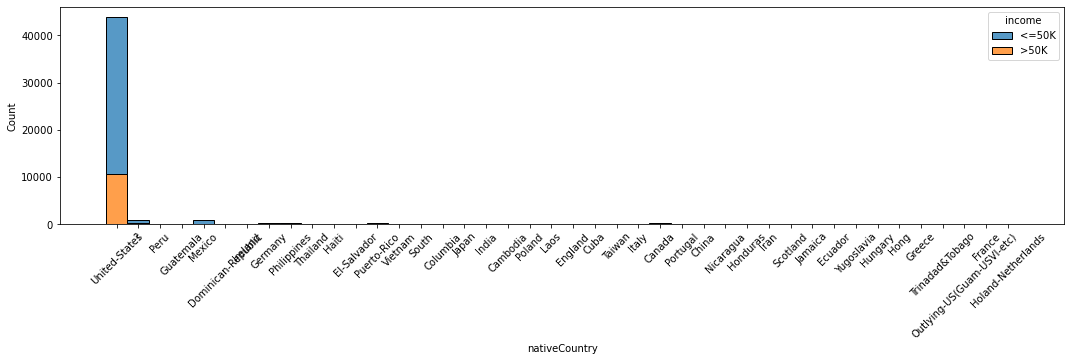

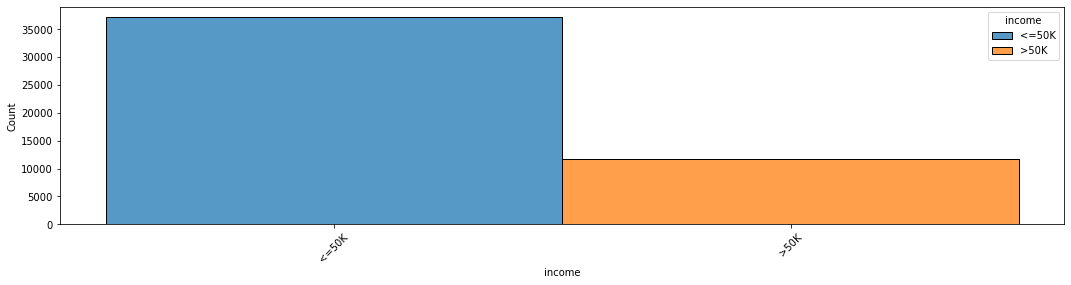

In [14]:
# get all feature names in list
all_features = [var for var in dataset.columns]

# plot histogram of all the features stacked by income
for v in all_features:
    show_stacked_histogram(dataset[v], dataset['income'])

##### Observations:
1. There is a significant amount of variance between the ratio of >50k to <=50k. The most interesting age groups to notice are  <20, 71-80 and 81-90 where there is almost no chance to have an income of greater than 50K
2. A higher level of education is correlated to a higher percentage of individuals with the label >50k
3. A majority of the individuals work in the private sector. Federal gov and self employed work class have high income
4. Occupations with managerial positions and professional speciality yeild high income
5. Working hours seem to have positive correlation with income 
6. The sample size of whites in the dataset is disproportionately large in comparison to all other races. The second most represented group is blacks with less than 5000 entries. The lack of equal distribution cause us to consider not utilizing this attribute in our prediction model
7. The percentage of males who make greater than 50K is much greater than the those of females that make the same amount. This may be a significant factor, and should be a considered in our prediction model
8. capital gain and capital loss have major proportion of zero (0) values and may not be influencing the income. So, these can also be removed later during pre-processing

#### Let's check the count of target variable i.e. income

In [15]:
# count of adults having income <=50K and >50K respectively
dataset['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

The proportion of adults having income upto 50K is large compared to that of adults having income more than 50K. This is a class imbalance problem and we may have to do sampling during data pre-processing.

#### Print a boxplot of numerical features to review outliers

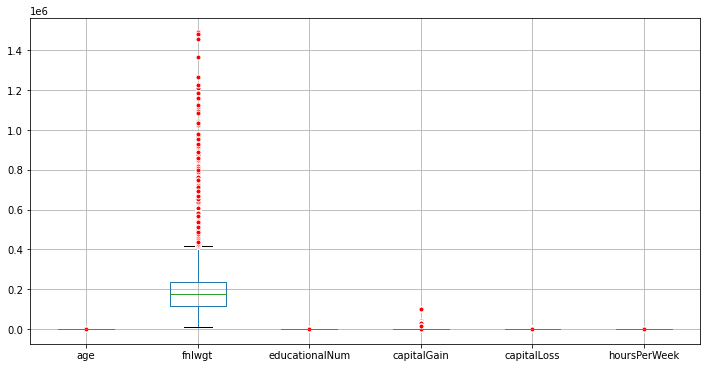

In [16]:
# boxplot to check the distribution of numerical features
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white',  markersize=5)
dataset[numerical_features].boxplot(figsize=(12,6), flierprops=red_circle)
plt.show()

The above boxplot shows that there are outliers in dataset that would need to be dealt with during pre-processing. Normalization of fnlwgt  will also be required.

#### Review the correlation between the numerical features 

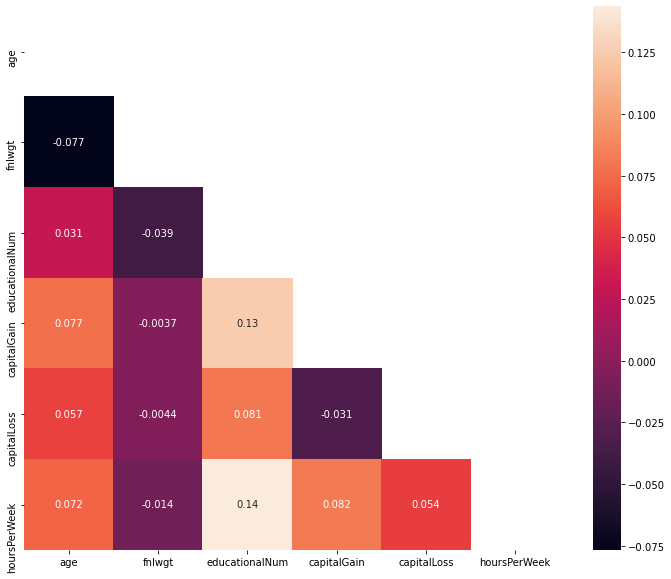

In [17]:
# show the correlation between the numerical features
show_heat_map(dataset)

Above heatmap shows that the numerical features in their current form do not show any significant correlation.
<h4> Note: </h4> The exploratory analysis done so far was using numerical and categorical features in their original forms as provided in dataset.

------------------------------------------------------------------------------------------------

In [18]:
"""
# R&D code
# check if two features are same
lookup_education = dict(zip(dataset['educationalNum'].unique(), dataset['education'].unique()))
lookup_education
"""

"\n# R&D code\n# check if two features are same\nlookup_education = dict(zip(dataset['educationalNum'].unique(), dataset['education'].unique()))\nlookup_education\n"

### Data Pre-Processing and Cleaning

#### 1. Remove null or missing values or noise

During data exploration, we found that few features in dataset have a "?" value. Let’s get the count of "?" characters present in those features.

In [19]:
# find the special character "?" in the dataset
dataset.isin(['?']).sum(axis=0)

age                  0
workclass         2799
fnlwgt               0
education            0
educationalNum       0
maritalStatus        0
occupation        2809
relationship         0
race                 0
gender               0
capitalGain          0
capitalLoss          0
hoursPerWeek         0
nativeCountry      857
income               0
dtype: int64

It can be seen above that workclass, occupation and nativeCountry have significant number of "?" values. Such values are not advisable for use in training and thus we will remove data rows that have "?" values in these features. Note that since the count of such rows is very low compared to total data rows, so removing them may not have significant impact on training and evaluation of machine learning models.

In [20]:
# code will replace the "?" character to nan
dataset['nativeCountry'] = dataset['nativeCountry'].replace('?', np.nan)
dataset['workclass'] = dataset['workclass'].replace('?', np.nan)
dataset['occupation'] = dataset['occupation'].replace('?', np.nan)

# drop the rows if any missing (nan) values are present in them
dataset.dropna(how='any', inplace=True)

All rows having "?" values in features are now removed from dataset.

In [21]:
# check the shape of data after removal of rows from above step
print(dataset.shape)

print('\nThe updated dataset has {} rows and {} columns'.format(dataset.shape[0], dataset.shape[1]))

(45222, 15)

The updated dataset has 45222 rows and 15 columns


In [22]:
# re-check the count of adults having income <=50K and >50K respectively in the updated dataset
dataset['income'].value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

The removal of rows have not caused any significant change in the proportion of <=50K and >50K.

Exploratory analysis showed that the capitalGain and capitalLoss have a very high proportion of 0 values which may not be useful for training. Also, the proportion of whites in race feature is disproportionalely very large compared to races other than white. So, we will drop these features from processing.

#### Drop irrelevant features identified by exploratory analysis

In [23]:
# drop capitalGain and capitalLoss from the dataset
dataset.drop(['capitalGain', 'capitalLoss', 'race'], axis=1, inplace=True)

#### 2. Identify outliers and remove

During exploration, we observed that there are outliers in numerical features. Let's check that again for numerical features in the updated dataset.

Let's view the boxplot to visualize the outliers.


Boxplot of numerical features:


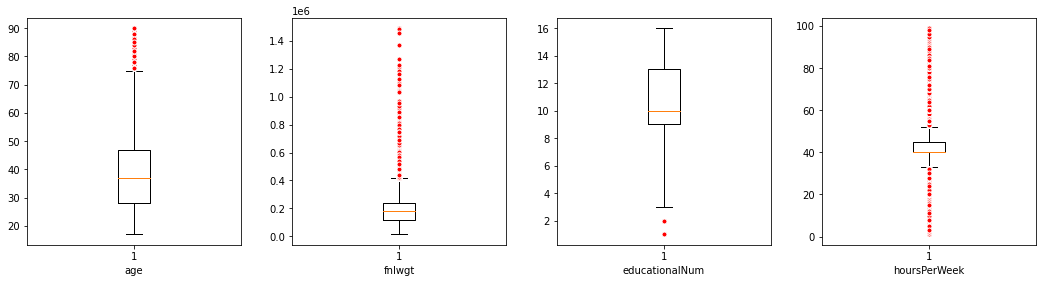

In [24]:
# print boxplot to check the distribution of numerical features

print("\nBoxplot of numerical features:")

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white',  markersize=5)
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(15,4))
fig.tight_layout(pad=2) # for distance between the sub-plots

ax1.boxplot(dataset.age, flierprops=red_circle)
ax1.set_xlabel('age')

ax2.boxplot(dataset.fnlwgt, flierprops=red_circle)
ax2.set_xlabel('fnlwgt')

ax3.boxplot(dataset.educationalNum, flierprops=red_circle)
ax3.set_xlabel('educationalNum')

ax4.boxplot(dataset.hoursPerWeek, flierprops=red_circle)
ax4.set_xlabel('hoursPerWeek')

plt.show()

It can be seen above that outliers exist, so we will find outliers and remove them. 

In [25]:
# get numerical feature names in list
mumerical_features = [var for var in dataset.columns if dataset[var].dtype=='int64']

all_outliers = [] # emply list to store indices of outliers

# loop to get and print the % of outliers
for v in mumerical_features:
    outliers = identify_outliers_Zscore(dataset, dataset[v].name)
    outlier_cnt = len(identify_outliers_Zscore(dataset, dataset[v].name))
    print('# of Outliers in {} \t : {} ({:.2f}%)'.format(dataset[v].name, outlier_cnt, (outlier_cnt*100)/len(dataset[v])))
    all_outliers= list(set(all_outliers) | set(outliers))

print('\nThere are total {} rows in data having outliers in numerical features so far.'.format(len(all_outliers)))

# drop rows having outliers in features
dataset.drop(all_outliers, inplace=True)

# check the shape of updated dataset
print('\nAfter removing the outliers, the dataset is left with {} rows.'.format(dataset.shape[0]))

# of Outliers in age 	 : 163 (0.36%)
# of Outliers in fnlwgt 	 : 471 (1.04%)
# of Outliers in educationalNum 	 : 294 (0.65%)
# of Outliers in hoursPerWeek 	 : 626 (1.38%)

There are total 1522 rows in data having outliers in numerical features so far.

After removing the outliers, the dataset is left with 43700 rows.


#### 3. Check for skewness in features and normalize

In [26]:
# check skewness of data
print(dataset.skew())

age               0.444481
fnlwgt            0.633231
educationalNum   -0.156917
hoursPerWeek     -0.266908
dtype: float64


fnlweight is moderatively positively skewed, so we will reduce its skewness.

In [27]:
# removing skewness using sqrt transformation
dataset['fnlwgt'] = dataset['fnlwgt'].map(lambda x: np.sqrt(x))
print(dataset.skew())

age               0.444481
fnlwgt           -0.099185
educationalNum   -0.156917
hoursPerWeek     -0.266908
dtype: float64


Now, the skewness of features are within the acceptable limits of <0.5 and >-0.5.

#### 4. Convert categorical features into numerical features

Machine learning requires numerical representation of features to extract patterns and make predictions. But since, some features provided in the dataset in categorical form so those would need to be converted into numerical forms.

In [28]:
# get remaining categorical features
categorical_features = [var for var in dataset.columns if dataset[var].dtype=='O']
print('\nThere are {} categorical features remaining in dataset listed below:\n{}'.format(len(categorical_features), categorical_features))

# view the unique values for categorical features and their respective counts
for v in categorical_features:
    print ("\n----- %s -----" % v)
    print (dataset[v].value_counts())


There are 8 categorical features remaining in dataset listed below:
['workclass', 'education', 'maritalStatus', 'occupation', 'relationship', 'gender', 'nativeCountry', 'income']

----- workclass -----
Private             32281
Self-emp-not-inc     3547
Local-gov            3025
State-gov            1900
Self-emp-inc         1554
Federal-gov          1372
Without-pay            21
Name: workclass, dtype: int64

----- education -----
HS-grad         14373
Some-college     9661
Bachelors        7391
Masters          2451
Assoc-voc        1918
11th             1576
Assoc-acdm       1474
10th             1178
7th-8th           776
Prof-school       739
9th               656
12th              559
Doctorate         514
5th-6th           434
Name: education, dtype: int64

----- maritalStatus -----
Married-civ-spouse       20275
Never-married            14183
Divorced                  6151
Separated                 1364
Widowed                   1185
Married-spouse-absent      513
Married-AF-

#### 5. Convert feature types

In [29]:
# mapping income to 0 and 1 as there are only two values
dataset['income'] = dataset['income'].map({'<=50K': 0, '>50K': 1}).astype(int)

Now, gender has 2 values - either 'Male' or 'Female', so we map values to  1 and 0 for them respectively

In [30]:
# mapping gender to 0 and 1 as there are only two values
dataset['gender'] = dataset['gender'].map({'Female': 0, 'Male': 1}).astype(int)

During exploration, we observed that a very high proportion of value in nativeCountry feature is "United-States". So, we consider the data into "United-States" and "Non United-States". Then map them to 1 and 0 respectively.

We also tried using ordinal encoding and one-hot encoding of nativeCountry but it was not showing any significant difference in the accuracy of model.

In [31]:
# mapping nativeCountry
dataset['nativeCountry'] = dataset['nativeCountry'].map({'Italy': 0,
                                                           'Puerto-Rico': 0, 
                                                           'Haiti': 0,
                                                           'Portugal': 0,
                                                           'England': 0,
                                                           'France': 0,
                                                           'Iran': 0,
                                                           'Greece': 0, 'Dominican-Republic': 0, 'Canada': 0,
                                                           'Cambodia': 0, 
                                                           'Hong': 0, 
                                                           'Outlying-US(Guam-USVI-etc)': 0, 
                                                           'Ireland': 0, 
                                                           'South': 0, 
                                                           'Scotland': 0, 
                                                           'Poland': 0, 
                                                           'Peru': 0, 
                                                           'El-Salvador': 0, 
                                                           'Ecuador': 0, 
                                                           'Cuba': 0, 
                                                           'Jamaica': 0, 
                                                           'Philippines': 0, 
                                                           'Taiwan': 0, 
                                                           'China': 0, 
                                                           'Germany': 0, 
                                                           'Yugoslavia': 0, 
                                                           'India': 0, 
                                                           'Holand-Netherlands': 0, 
                                                           'Honduras': 0, 
                                                           'Guatemala': 0, 
                                                           'United-States': 1, 
                                                           'Vietnam': 0, 
                                                           'Nicaragua': 0, 
                                                           'Thailand': 0, 
                                                           'Hungary': 0, 
                                                           'Mexico': 0, 
                                                           'Trinadad&Tobago': 0, 
                                                           'Japan': 0, 
                                                           'Columbia': 0, 
                                                           'Laos': 0}).astype(int)

We certainly saw in histogram plotted during exploration that adults with higher education are paid more. Hence, we treat education as an ordinal feature, and we will replace the values with numbers from 1,2,3,.....16. However, this could be a duplicate of educationNum feature and can be removed later if a correlation is established.

In [32]:
# education
dataset['education'] = dataset['education'].map({'Preschool': 1, 
                                                 '1st-4th': 2, 
                                                 '5th-6th': 3, 
                                                 '7th-8th': 4, 
                                                 '9th': 5, 
                                                 '10th': 6, 
                                                 '11th': 7,
                                                 '12th': 8, 
                                                 'HS-grad': 9, 
                                                 'Some-college': 10, 
                                                 'Assoc-voc': 11,
                                                 'Assoc-acdm': 12, 
                                                 'Bachelors': 13,
                                                 'Masters': 14,
                                                 'Prof-school': 15,
                                                 'Doctorate': 16}).astype(int)

During exploration, we observed that maritalStatus is not having any significant influence on income > or <=50K. See the distribution below. So, this feature is also not likely to be useful for prediction model. So we will drop it.

Note that we tried one hot encoding for this feature but it was not yielding any better results in terms of accuracy of model.

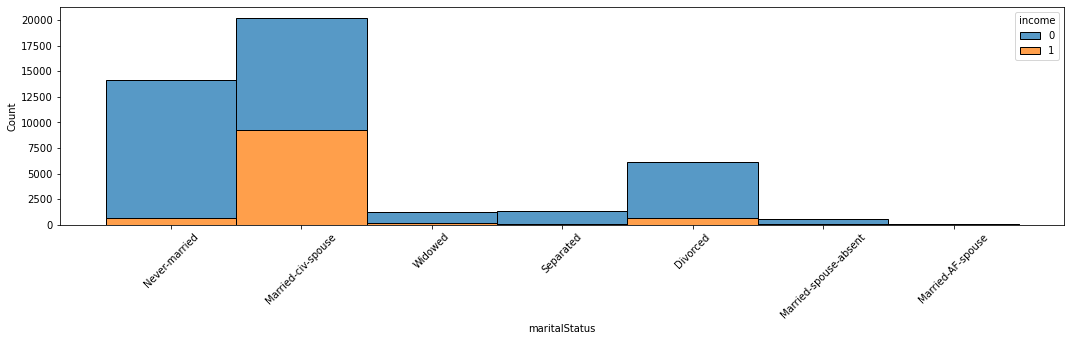

In [33]:
# show distribution of maritalStatus w.r.t. income
show_stacked_histogram(dataset['maritalStatus'], dataset['income'])

In [34]:
# drop maritalStatus from dataset 
dataset.drop(['maritalStatus'], axis=1, inplace=True)

#### 6. Correlation analysis

Now that few of the features are converted into numerical form, let's re-check the correlation among all the numerical features in the dataset.

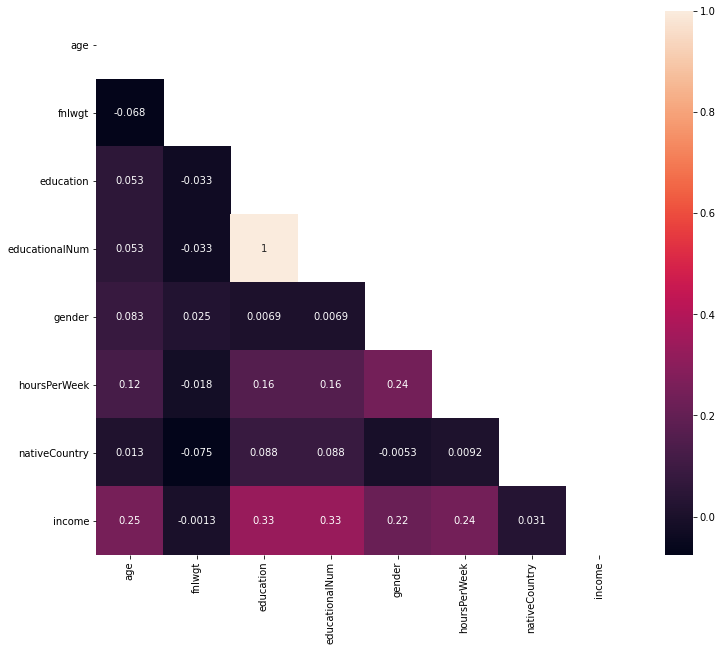

In [35]:
# dataset.corr()
show_heat_map(dataset)

#### Observations from above:
1. education and educationalNum have a perfect correlation, and they be considered duplicate of each other, so one of them can be dropped
2. fnlwgt has no significant correlation with income
3. nativeCountry has no significant correlation with income

* So, we will drop education, fnlwgt and nativeCountry from the dataset

In [36]:
# drop education, fnlwgt and nativeCountry from dataset 
dataset.drop(['education', 'fnlwgt', 'nativeCountry'], axis=1, inplace=True)

We tried to drop relationship feature also initially from the dataset but that was impacting the accuracy of all models so kept it.

#### 7. Features chosen for modeling

In [37]:
# get all feature names in list
all_features = [var for var in dataset.columns]

# print final features
print("The list of features selected for model training available is below:\n{}".format(all_features))

The list of features selected for model training available is below:
['age', 'workclass', 'educationalNum', 'occupation', 'relationship', 'gender', 'hoursPerWeek', 'income']


#### 8. Split the sample space into training and test data for predictors and target variable

In [38]:
# create predictor sample space using all features excluding income
X = dataset.loc[:, dataset.columns != 'income']

# create target sample space
Y = dataset['income']

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, stratify=Y, test_size= 0.3, random_state=0)

# The dataset is split into two - training data and testing data
# The ratio of split is given by the parameter test_size. 0.3 means that 30% of data is chosen for test
# randam_state is the seed for the random number generator for reproducible results

We will do one-hot encoding of remaining categorical features.

In [39]:
encoder = ce.OneHotEncoder(cols=['workclass', 'occupation', 'relationship'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

#### 9. Sampling
* We noticed while doing exploratory analysis that the dataset is imbalanced towards <=50K target variable. The representation of <=50K and that of >50K is approximately in 3:1 ratio. 

* When we trained our models on this representation of data, the accuracy of predicting <=50K was satisfactorily very high of ~85% however the accuracy of predicting >50K was quite less in range of 45-52% only. This is due to the imbalanced dataset

* So, we tried sampling to make equal representations and that improved results. Predictions of >50K improved to 60+%

* We tried oversampling, undersampling and SMOTE sampling. Since SMOTE was giving best accuracy during model evaluation for all the modeling techniques, hence it was chosen

The performance results of all the chosen machine learning models using oversampling and undersampling is not recorded in this notebook to avoid over-documentation.

In [40]:
# generate synthetic samples (SMOTE)
sm = SMOTE(random_state=0)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

# print the counts of training data having income <=50K and >50K respectively
print(Y_train.value_counts())

0    22981
1    22981
Name: income, dtype: int64


Now, the training data is balanced so there will not be a bias towards prediction of target labels.

------------------------------------------------------------------------------------------------

### Model Building & Evaluation

We have chosen below machine learning models for solving this problem:
1. Logistic Regression
2. Decision Tree Classifier
3. Gaussian Naive Bayes Classifier

### Model 1 - Logistic Regression

In [41]:
# initialize logistic regression model and train
logistic_model = LogisticRegression(max_iter=500, solver='lbfgs')

# we are chosing solver='lbfgs', max_iter=100
# hyper param tuning- l1 , l2 reg

# train the model
logistic_model.fit(X_train, Y_train)

C:\Users\A621011\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

The model is not converging within the maximum iterations value used, so we will increase the max_iter parameter in next run for tuning the hyper-parameters.

#### Predict target variable

In [42]:
# predict the target variable for the test data
Y_pred_log = logistic_model.predict(X_test)

#### Training and test accuracy

In [43]:
# print training and test accuracy
print('Training set accuracy score \t: {:.4f}'.format(logistic_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(logistic_model.score(X_test, Y_test)))

Training set accuracy score 	: 0.8524
Test set accuracy score 	: 0.8207


The above accuracy scores of training and test dataset are comparable, so there is no sign of overfitting or underfitting.

#### Loss values

In [44]:
# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_log)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_log)))

AUC-ROC score 	: 0.7909
Log-loss score 	: 6.1939


AUC value is high i.e. 0.79 (>> 0.5) which shows that the area ROC curve is high and that prediction mode is good. We will compate the log loss value of this model with other models after evaluating their performance.

### Performance Evaluation

#### Confusion Matrix

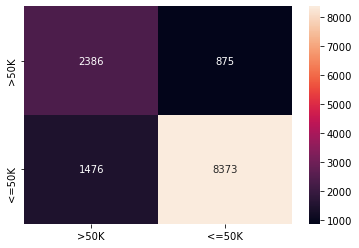

In [45]:
# print confusion matrix
cm_logistic = confusion_matrix(Y_test, Y_pred_log, labels=[1,0]) 
# print('Confusion matrix:\n\n', cm_logistic)
sns.heatmap(cm_logistic, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

##### Observations from confusion matrix:
1. True Positive (TP) = 2386; 2386 (62%) of >50K income are correctly classified by the model
2. True Negative (TN) = 8383; 8383 (91%) of <=50K income are correctly classified by the model
3. False Positive (FP) = 875; 875 of <=50K income are incorrectly classified as belonging to >50K income class
4. False Negative (FN) = 1476; 1476 of >50K income are incorrectly classified as belonging to <=50K income class

* Type-I error i.e. FP = 875
* Type-II error i.e. FN = 1476

The model is predicting <=50K with high precision, however it is low for >50K.

#### Classification Report

In [46]:
# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_log, labels=[1,0]))

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.62      0.73      0.67      3261
           0       0.91      0.85      0.88      9849

    accuracy                           0.82     13110
   macro avg       0.76      0.79      0.77     13110
weighted avg       0.83      0.82      0.83     13110



##### Observations from classification report:
1. As can be seen in the above classification report, the precision of classifying <=50K income is 91% which is high as compared to that of >50K income classification which is 62%
2. Recall for both <=50K and >50K are 85% and 73% respectively which are good
3. The f1-score for both and overall accuracy (82%) of model is good

In [47]:
# R&D code
error_df = Y_test[Y_pred_log != Y_test]
error_df.value_counts()

0    1476
1     875
Name: income, dtype: int64

### Model 2 - Decision Tree

In [48]:
# instantiate the DecisionTreeClassifier model using criterion gini index
dtree_model = DecisionTreeClassifier(criterion='gini', max_depth=5)

# fit the model
dtree_model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5)

#### Predict target variable

In [49]:
# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

#### Training and test accuracy

In [50]:
# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

Training set accuracy score 	: 0.7949
Test set accuracy score 	: 0.7783


The above accuracy scores of training and test dataset are comparable, so there is no sign of overfitting or underfitting.

#### Loss values

In [51]:
# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_dtree)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_dtree)))

AUC-ROC score 	: 0.8004
Log-loss score 	: 7.6561


AUC value is high i.e. 0.80 (>> 0.5) which shows that the area ROC curve is high and that prediction mode is good. However, the log loss value of this classifier is high as compared to that of Logistic Regression model.

### Performance Evaluation

#### Confusion Matrix

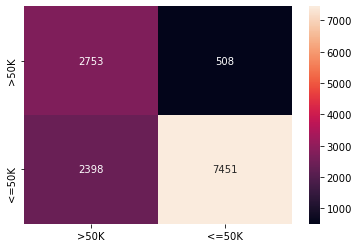

In [52]:
# print confusion matrix
cm_dtree = confusion_matrix(Y_test, Y_pred_dtree, labels=[1,0])
#print('Confusion matrix: \n\n', cm_dtree)
sns.heatmap(cm_dtree, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

##### Observations from confusion matrix:
1. True Positive (TP) = 2753; 2753 (53%) of >50K income are correctly classified by the model
2. True Negative (TN) = 7451; 7451 (94%) of <=50K income are correctly classified by the model
3. False Positive (FP) = 508; 508 of <=50K income are incorrectly classified as belonging to >50K income class
4. False Negative (FN) = 2398; 2398 of >50K income are incorrectly classified as belonging to <=50K income class

* Type-I error i.e. FP = 508
* Type-II error i.e. FN = 2398

The model is predicting <=50K with high precision, however it is low for >50K.

#### Classification Report

In [53]:
# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_dtree, labels=[1,0]))

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.53      0.84      0.65      3261
           0       0.94      0.76      0.84      9849

    accuracy                           0.78     13110
   macro avg       0.74      0.80      0.75     13110
weighted avg       0.84      0.78      0.79     13110



##### Observations from classification report:
1. As can be seen in the above classification report, the precision of classifying <=50K income is 94% which is quite high as compared to that of >50K income classification which is 53%
2. Recall for both <=50K and >50K are 84% and 76% respectively which are good
3. The f1-score for both and overall accuracy (78%) of model is good

### Model 3 - Gaussian NB Classifier

In [54]:
# instantiate the GNB classifier model
gnb_model = GaussianNB()

# fit the model
gnb_model.fit(X_train, Y_train)

GaussianNB()

#### Predict target variable

In [55]:
# predict the target variable for the test data
Y_pred_gnb = gnb_model.predict(X_test)

#### Training and test accuracy

In [56]:
# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(gnb_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(gnb_model.score(X_test, Y_test)))

Training set accuracy score 	: 0.7735
Test set accuracy score 	: 0.6752


The above accuracy scores of training and test dataset are significantly varying. So, GNB classifier doesn't seem to predict the income with high accuracy.

#### Loss value

In [57]:
# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_gnb)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_gnb)))

AUC-ROC score 	: 0.7445
Log-loss score 	: 11.2181


AUC value is high i.e. 0.74 (>> 0.5) which shows that the area ROC curve is high and that prediction mode is good. However, the log loss value of this classifier is very high as compared to that of Logistic Regression and Decision Tree classifier.

### Performance Evaluation

#### Confusion Matrix

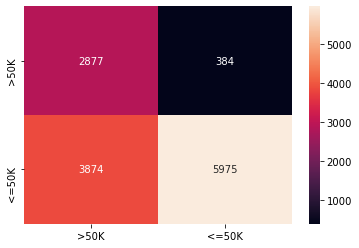

In [58]:
# print confusion matrix
cm_gnb = confusion_matrix(Y_test, Y_pred_gnb, labels=[1,0])
#print('Confusion matrix: \n\n', cm_dtree)
sns.heatmap(cm_gnb, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

#### Observations from confusion matrix:
1. True Positive (TP) = 2877; 2877 (43%) of >50K income are correctly classified by the model
2. True Negative (TN) = 5975; 5975 (94%) of <=50K income are correctly classified by the model
3. False Positive (FP) = 384; 384 of <=50K income are incorrectly classified as belonging to >50K income class
4. False Negative (FN) = 3874; 3874 of >50K income are incorrectly classified as belonging to <=50K income class

* Type-I error i.e. FP = 384
* Type-II error i.e. FN = 3874

The model is predicting <=50K with high precision, however it is low for >50K.

#### Classification Report

In [59]:
# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_gnb, labels=[1,0]))

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.43      0.88      0.57      3261
           0       0.94      0.61      0.74      9849

    accuracy                           0.68     13110
   macro avg       0.68      0.74      0.66     13110
weighted avg       0.81      0.68      0.70     13110



##### Observations from classification report:
1. As can be seen in the above classification report, the precision of classifying <=50K income is 94% which is quite high as compared to that of >50K income classification which is 43%
2. Recall for both <=50K and >50K are 88% and 61% respectively which are not that bad
3. The f1-score for both and overall accuracy (88%) is poor as compared to that of Logictic Regression and Decision Tree classifier

### Hyper-parameter tuning of above 3 models to improve the results

Unlike having one cell for explaining each step i.e. modeling, prediction, accuracy printing, confusion matrix and classification report done above for the 3 models chosen, the code per iteration of learning, test and results is placed within a single cell to keep the document simple and logical.

#### 1. Logistic Regression - iteration 2,3,4

Hyper-parameters chosen:
1. max_iter = 1000, then 1500 and 2000
2. solver = lbfgs

C:\Users\A621011\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC-ROC score 	: 0.7922
Log-loss score 	: 6.1596
Training set accuracy score 	: 0.8527
Test set accuracy scoree 	: 0.8217


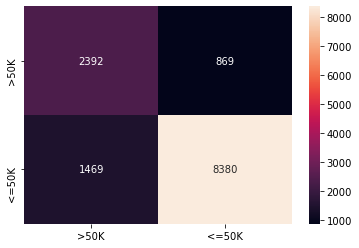

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.62      0.73      0.67      3261
           0       0.91      0.85      0.88      9849

    accuracy                           0.82     13110
   macro avg       0.76      0.79      0.77     13110
weighted avg       0.83      0.82      0.83     13110



In [60]:
# re-run logistic regression with updated hyper-parameters

# initialize logistic regression model and train
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs')

# Train the model
logistic_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_log = logistic_model.predict(X_test)

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_log)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_log)))

# print training and test accuracy
print('Training set accuracy score \t: {:.4f}'.format(logistic_model.score(X_train, Y_train)))
print('Test set accuracy scoree \t: {:.4f}'.format(logistic_model.score(X_test, Y_test)))

# print confusion matrix
cm_logistic = confusion_matrix(Y_test, Y_pred_log, labels=[1,0]) 
#print('\nConfusion matrix:\n\n', cm_logistic)
sns.heatmap(cm_logistic, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_log, labels=[1,0]))

Observations: Cosmetic improvements in results, however the model is not converging with max_iters = 1000 as well.

We increased max_iters increased to 1500 and then to 2000 but the model was still not converging, and also, there was no significant change observed in accuracy, precision and recall values.

#### 2. Logistic Regression - iteration 5, 6, 7

Hyper-parameters chosen:
1. max_iter = 500, then 1000, 1500 and 2000
2. solver = liblinear

AUC-ROC score 	: 0.7928
Log-loss score 	: 6.1465
Training set accuracy score 	: 0.8524
Test set accuracy scoree 	: 0.8220


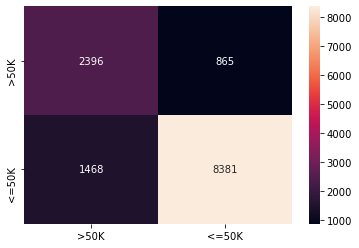

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.62      0.73      0.67      3261
           0       0.91      0.85      0.88      9849

    accuracy                           0.82     13110
   macro avg       0.76      0.79      0.78     13110
weighted avg       0.84      0.82      0.83     13110



In [61]:
# re-run logistic regression with updated hyper-parameters

# initialize logistic regression model and train
logistic_model = LogisticRegression(max_iter=500, solver='liblinear')

# Train the model
logistic_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_log = logistic_model.predict(X_test)

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_log)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_log)))

# print training and test accuracy
print('Training set accuracy score \t: {:.4f}'.format(logistic_model.score(X_train, Y_train)))
print('Test set accuracy scoree \t: {:.4f}'.format(logistic_model.score(X_test, Y_test)))

# print confusion matrix
cm_logistic = confusion_matrix(Y_test, Y_pred_log, labels=[1,0]) 
#print('\nConfusion matrix:\n\n', cm_logistic)
sns.heatmap(cm_logistic, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_log, labels=[1,0]))

Observations: No improvements seen in the results. We tried increasing the max_iters to 1000, 1500 and 2000 but the results were same.

#### 3. Logistic Regression - iteration 8, 9, 10, 11

Hyper-parameters chosen:
1. max_iter = 500, then 1000, 1500 and 2000
2. solver = liblinear, sag, saga and newton-cg

Tried above solver and max_iter values with various combinations of penalty values but there was no improvement in the results.

#### 4. Decision Tree Classifier - iteration 2

Hyper-parameters chosen:
1. criterion = entropy
2. max_depth = 5

AUC-ROC score 	: 0.8002
Log-loss score 	: 7.5455
Training set accuracy score 	: 0.7929
Test set accuracy score 	: 0.7815


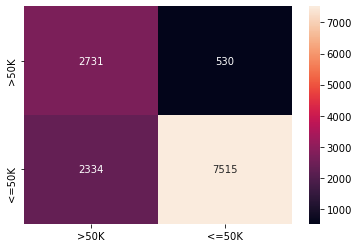

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.54      0.84      0.66      3261
           0       0.93      0.76      0.84      9849

    accuracy                           0.78     13110
   macro avg       0.74      0.80      0.75     13110
weighted avg       0.84      0.78      0.79     13110



In [62]:
# re-run decision tree classifier with updated hyper-parameters

# instantiate the DecisionTreeClassifier model
dtree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# fit the model
dtree_model.fit(X_train, Y_train)

# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_dtree)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_dtree)))

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

# print confusion matrix
cm_dtree = confusion_matrix(Y_test, Y_pred_dtree, labels=[1,0])
#print('Confusion matrix: \n\n', cm_dtree)
sns.heatmap(cm_dtree, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_dtree, labels=[1,0]))

Observations: No significant improvements in results seen.

#### 5. Decision Tree Classifier - iteration 3

Hyper-parameters chosen:
1. criterion = gini
2. max_depth = 5
3. random_state = multiple values chosen iteratively

Training set accuracy score 	: 0.7949
Test set accuracy score 	: 0.7783


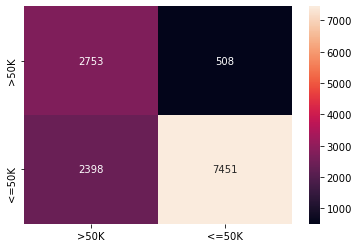

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.53      0.84      0.65      3261
           0       0.94      0.76      0.84      9849

    accuracy                           0.78     13110
   macro avg       0.74      0.80      0.75     13110
weighted avg       0.84      0.78      0.79     13110



In [63]:
# re-run decision tree classifier with updated hyper-parameters

# instantiate the DecisionTreeClassifier model
dtree_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=3)

# fit the model
dtree_model.fit(X_train, Y_train)

# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

# print confusion matrix
cm_dtree = confusion_matrix(Y_test, Y_pred_dtree, labels=[1,0])
#print('Confusion matrix: \n\n', cm_dtree)
sns.heatmap(cm_dtree, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_dtree, labels=[1,0]))

Observations: No significant improvements in results seen. Various combinations of random_state and criterion were chosen.

#### 6. Decision Tree Classifier - iteration 4

Hyper-parameters chosen:
1. criterion = gini
2. max_depth = 7, then 8, 9
3. random_state = multiple values chosen iteratively

AUC-ROC score 	: 0.7956
Log-loss score 	: 7.3874
Training set accuracy score 	: 0.8276
Test set accuracy score 	: 0.7861


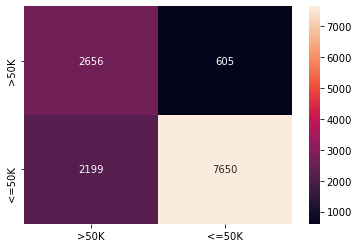

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.55      0.81      0.65      3261
           0       0.93      0.78      0.85      9849

    accuracy                           0.79     13110
   macro avg       0.74      0.80      0.75     13110
weighted avg       0.83      0.79      0.80     13110



In [64]:
# re-run decision tree classifier with updated hyper-parameters

# instantiate the DecisionTreeClassifier model
dtree_model = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42)

# fit the model
dtree_model.fit(X_train, Y_train)

# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_dtree)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_dtree)))

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

# print confusion matrix
cm_dtree = confusion_matrix(Y_test, Y_pred_dtree, labels=[1,0])
#print('Confusion matrix: \n\n', cm_dtree)
sns.heatmap(cm_dtree, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_dtree, labels=[1,0]))

Observations: After changing the max_depth value to 7, minor improvement in precision of >50k income and the overall accuracy were observed. Then we changes the max_depth value to 8 and 9 but no improvements were noticed.
* The above combination has given us best results from Decision Tree Classifier so far.

#### 7. Gaussian NB Classifier - iteration 2

Hyper-parameters chosen:
1. var_smoothing = 1e-06, then 1e-07 and then 1e-08

AUC-ROC score 	: 0.7446
Log-loss score 	: 11.2102
Training set accuracy score 	: 0.7736
Test set accuracy score 	: 0.6754


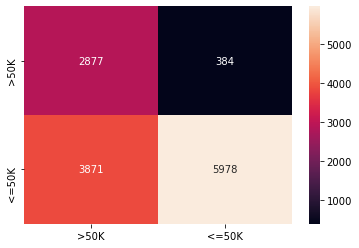

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.43      0.88      0.57      3261
           0       0.94      0.61      0.74      9849

    accuracy                           0.68     13110
   macro avg       0.68      0.74      0.66     13110
weighted avg       0.81      0.68      0.70     13110



In [65]:
# re-run Gaussian NB classifier with updated hyper-parameters

# instantiate the GaussianNB model
gnb_model = GaussianNB(var_smoothing=1e-08)

# fit the model
gnb_model.fit(X_train, Y_train)

# predict test results
Y_pred_gnb = gnb_model.predict(X_test)

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_gnb)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_gnb)))

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(gnb_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(gnb_model.score(X_test, Y_test)))

# print confusion matrix
cm_gnb = confusion_matrix(Y_test, Y_pred_gnb, labels=[1,0])
#print('Confusion matrix: \n\n', cm_gnb)
sns.heatmap(cm_gnb, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_gnb, labels=[1,0]))

Observations: No significant improvements in accuracy or precision observed.

#### 7. Gaussian NB Classifier - iteration 3

Hyper-parameters chosen:
1. var_smoothing = 1e-10, then 1e-11 and then 1e-12

AUC-ROC score 	: 0.7445
Log-loss score 	: 11.2181
Training set accuracy score 	: 0.7735
Test set accuracy score 	: 0.6752


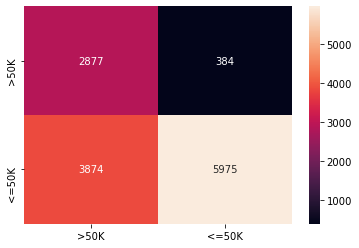

Classification report: 
 1: >50K 
 0: <=50K 
               precision    recall  f1-score   support

           1       0.43      0.88      0.57      3261
           0       0.94      0.61      0.74      9849

    accuracy                           0.68     13110
   macro avg       0.68      0.74      0.66     13110
weighted avg       0.81      0.68      0.70     13110



In [66]:
# re-run Gaussian NB classifier with updated hyper-parameters

# instantiate the GaussianNB model
gnb_model = GaussianNB(var_smoothing=1e-12)

# fit the model
gnb_model.fit(X_train, Y_train)

# predict test results
Y_pred_gnb = gnb_model.predict(X_test)

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_gnb)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_gnb)))

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(gnb_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(gnb_model.score(X_test, Y_test)))

# print confusion matrix
cm_gnb = confusion_matrix(Y_test, Y_pred_gnb, labels=[1,0])
#print('Confusion matrix: \n\n', cm_gnb)
sns.heatmap(cm_gnb, xticklabels=['>50K','<=50K'], yticklabels=['>50K','<=50K'], annot=True, fmt='g')
plt.show()

# print classification report
print('Classification report: \n 1: >50K \n 0: <=50K \n', classification_report(Y_test, Y_pred_gnb, labels=[1,0]))

Observations: No significant change in results compared to the first run

------------------------------------------------------------------------------------------------

### Conclusion

#### Gaussian NB Classifier:
This model was the least successful model as the data and predicts income >50k with the lowest precision. The log loss (11.21) is very high as compared to the other two models. The best overall accuracy achieved from this model was 68% (of which 43% of >50K and 94% of <=50K).

#### Decision Tree:
This model worked better as compared to the Gaussian NB Classifier. The log loss value of this model was 7.38 which is better than that of GNB classifier, the overall accuracy was 79% (of which 55% of >50K and 93% of <=50K) which is also better as compared to GNB classifier.

#### Logistic Regression:
This model worked the best out of all of our models giving the highest accuracy and least log loss. It was also predicting >50K income class at significant levels compared to the other two. It delivered lod loss of 6.14 and overall accuracy of 82% which includes 62% and 91% precision of >50K income and <=50K income respectively.

The type I and type II errors were also least for Logistic Regression model among the three which we used.

#### Training & Test Errors:

|Classifier|Train Error|Test Error|Log Loss|
|:---|:---|:---|:---|
|Logistic Regression|15.8%|17.8%|6.14|
|Decision Tree|17.2%|21.4%|7.38|
|Gaussian Naive Bayes|22.6%|32.5%|11.21|

- Train Error = (1 - Training accuracy)*100
- Test Error = (1 - Test accuracy)*100